In [12]:
# Common
import os
import cv2 as cv
from keras.metrics import MeanIoU
from tqdm import tqdm

# data 
import numpy as np 
from keras.preprocessing.image import load_img, img_to_array

# viz
import matplotlib.pyplot as plt

# Model
import keras 
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, BatchNormalization, Input, Conv2DTranspose, concatenate, GlobalAveragePooling2D, Dense
from keras import Sequential 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import tensorflow_datasets as tfds

In [2]:
def show_img(img, cmap=None, title=None):
    plt.imshow(img, cmap=cmap)
    if title:
        plt.title(title)
    plt.axis('off')

In [3]:
# images=[]
# mask=[]

# image_path='C:/TMLC/PROJECT 8 (SEGMENTATION)/Dataset/Water Bodies Dataset/Images/'
# mask_path='C:/TMLC/PROJECT 8 (SEGMENTATION)/Dataset/Water Bodies Dataset/Masks/'

# image_names=sorted(next(os.walk(image_path))[-1])
# mask_names=sorted(next(os.walk(mask_path))[-1])

# if image_names==mask_names:
#     print('Images and Masks are in sync')

In [4]:
img_size=(128, 128, 3)
input=tf.keras.layers.Input(shape=img_size)
s=tf.keras.layers.Lambda(lambda x: x/255)(input)

# Contraction Path
c1=Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1=Dropout(0.1)(c1)
c1=Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1=MaxPool2D((2, 2))(c1)

c2=Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2=Dropout(0.1)(c2)
c2=Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2=MaxPool2D((2, 2))(c2)

c3=Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3=Dropout(0.2)(c3)
c3=Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3=MaxPool2D((2, 2))(c3)

c4=Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4=Dropout(0.2)(c4)
c4=Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4=MaxPool2D((2, 2))(c4)

c5=Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5=Dropout(0.3)(c5)
c5=Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
#no maxpool for last layer in contraction path

# Expansion Path
u6=Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6=concatenate([u6, c4])
c6=Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6=Dropout(0.2)(c6)
c6=Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7=Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7=concatenate([u7, c3])
c7=Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7=Dropout(0.2)(c7)
c7=Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8=Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c7)
u8=concatenate([u8, c2])
c8=Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8=Dropout(0.1)(c8)
c8=Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9=Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', kernel_initializer='he_normal')(c8)
u9=concatenate([u9, c1])
c9=Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9=Dropout(0.1)(c9)
c9=Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs=tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model=tf.keras.Model(inputs=[input], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
checkpointer=ModelCheckpoint('model_for_watershed.keras', verbose=1, save_best_only=True)
callbacks=[EarlyStopping(patience=3, monitor='val_loss'), TensorBoard(log_dir='logs'), checkpointer]


In [15]:
images=[]
mask=[]

image_path='C:/TMLC/PROJECT 8 (SEGMENTATION)/Dataset/Water Bodies Dataset/Images/'
mask_path='C:/TMLC/PROJECT 8 (SEGMENTATION)/Dataset/Water Bodies Dataset/Masks/'

image_names=sorted(next(os.walk(image_path))[-1])
mask_names=sorted(next(os.walk(mask_path))[-1])

if image_names==mask_names:
    print('Images and Masks are in sync')

Images and Masks are in sync


In [16]:
SIZE = 128
images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
  path = image_path + image_names[id]
  img = img_to_array(load_img(path)).astype('float')/255.
  img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
  images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
  path = mask_path + mask_names[id]
  mask = img_to_array(load_img(path)).astype('float')/255.
  mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
  masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [01:15<00:00, 37.50it/s] 


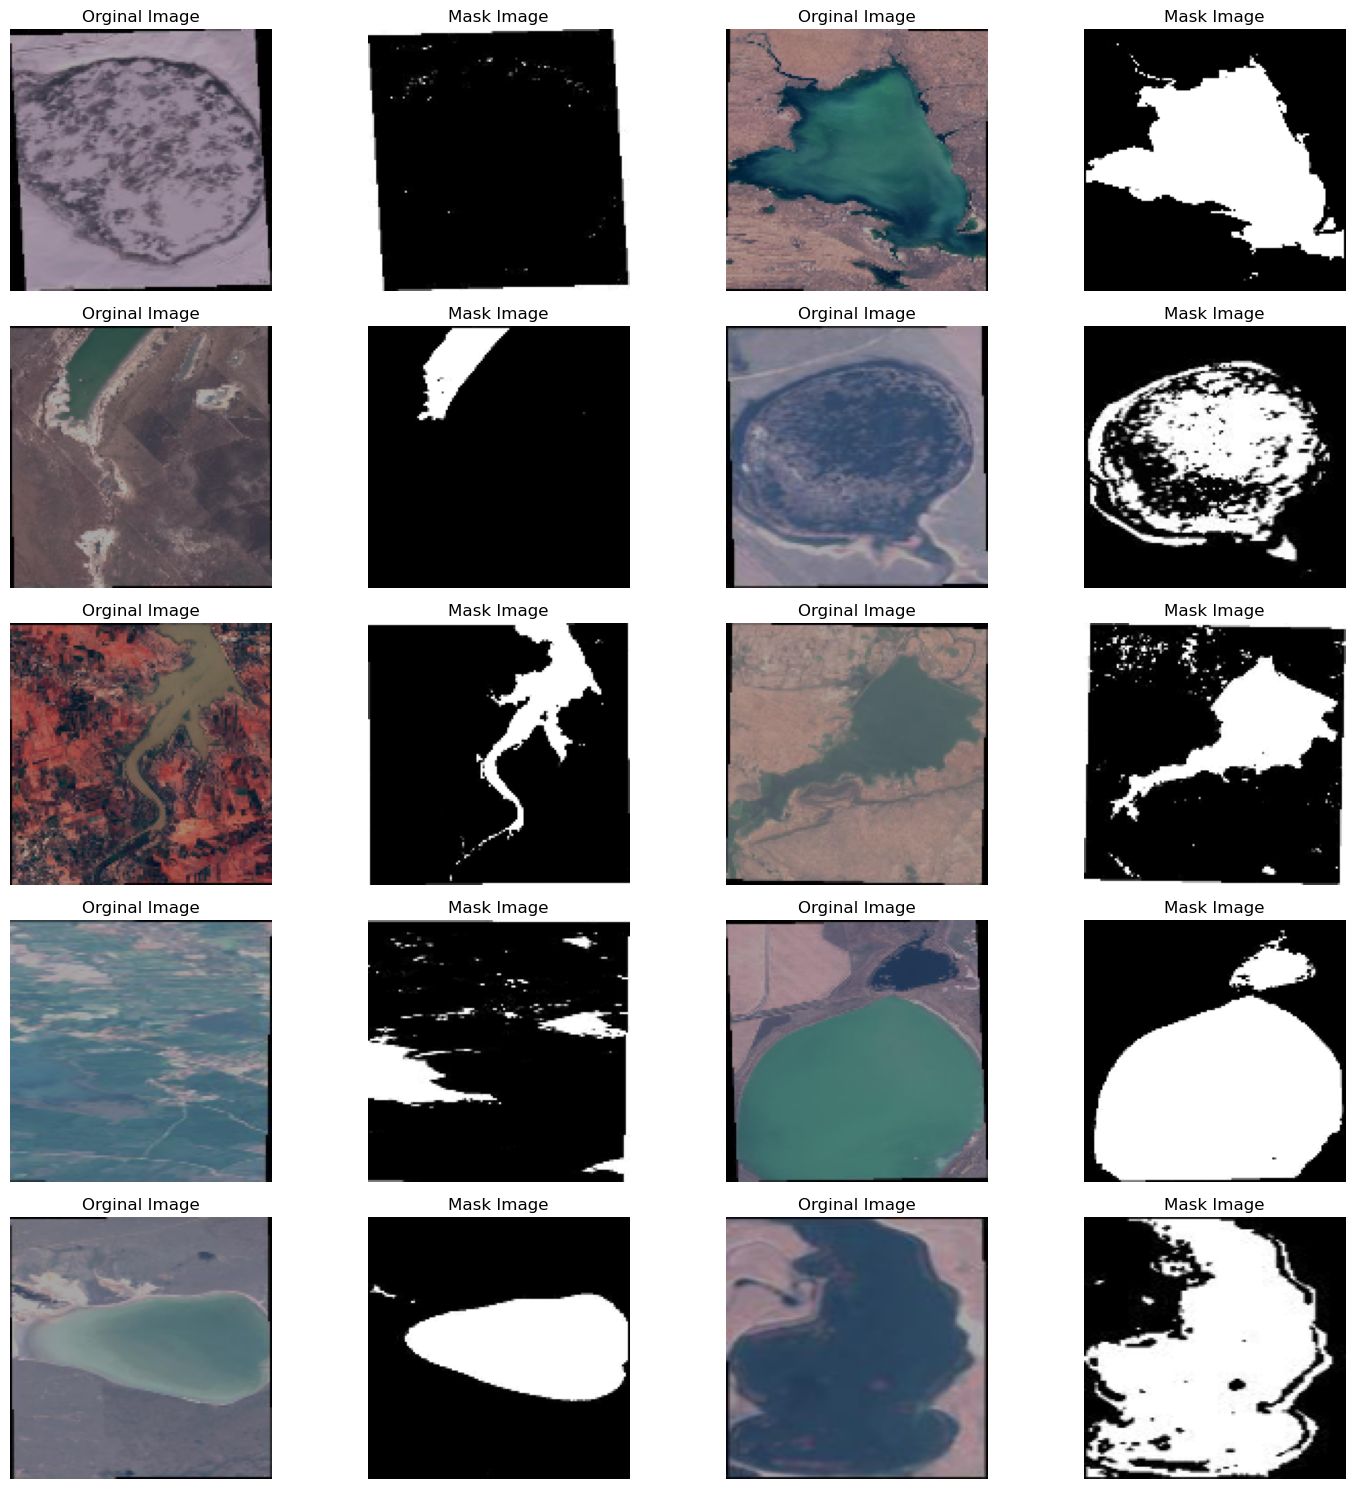

In [17]:
def show_image(img, title=None, cmap=None):
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.title(title)

plt.figure(figsize=(15,15))
for i in range(1,21):
  plt.subplot(5,4,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    show_image(images[id], title="Orginal Image")
  elif i%2==0:
    show_image(masks[id].reshape(128,128), title="Mask Image", cmap='gray')

plt.tight_layout()
plt.show()

In [18]:
X, y = images[:int(len(images)*0.9)], masks[:int(len(images)*0.9)]
test_X, test_y = images[int(len(images)*0.9):], masks[int(len(images)*0.9):]

In [20]:
# Callback 
class ShowProgress(keras.callbacks.Callback):
  def __init__(self, save=False):
    self.save = save
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(images))
    real_img = images[id][np.newaxis,...]
    pred_mask = self.model.predict(real_img).reshape(128,128)
    proc_mask1 = post_process(pred_mask)
    proc_mask2 = post_process(pred_mask, threshold=0.5)
    proc_mask3 = post_process(pred_mask, threshold=0.9)
    mask = masks[id].reshape(128,128)

    plt.figure(figsize=(10,5))

    plt.subplot(1,6,1)
    show_image(real_img[0], title="Orginal Image")

    plt.subplot(1,6,2)
    show_image(pred_mask, title="Predicted Mask", cmap='gray')
    
    plt.subplot(1,6,3)
    show_image(mask, title="Orginal Mask", cmap='gray')

    plt.subplot(1,6,4)
    show_image(proc_mask1, title="Processed@0.4", cmap='gray')

    plt.subplot(1,6,5)
    show_image(proc_mask2, title="Processed@0.5", cmap='gray')

    plt.subplot(1,6,6)
    show_image(proc_mask3, title="Processed@0.9", cmap='gray')

    plt.tight_layout()
    if self.save: plt.savefig("Progress-{}.png".format(epoch+1))
    plt.show()

# Post Process
def post_process(image,threshold=0.4):
  return image>threshold

In [21]:
checkpointer=ModelCheckpoint('model_for_watershed.keras', verbose=1, save_best_only=True)
callbacks=[EarlyStopping(patience=3, monitor='val_loss'), TensorBoard(log_dir='logs'), checkpointer, ShowProgress()]

Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 600ms/step - accuracy: 0.6178 - loss: 0.5324
Epoch 1: val_loss improved from inf to 0.47685, saving model to model_for_watershed.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


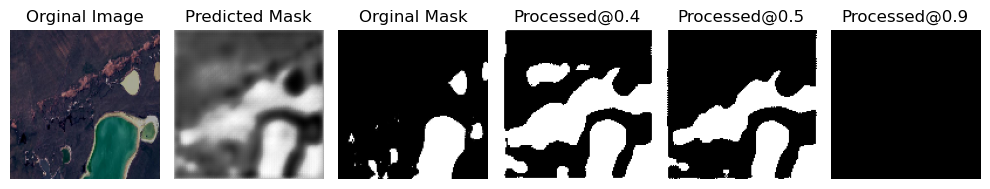

144/144 ━━━━━━━━━━━━━━━━━━━━ 94s 635ms/step - accuracy: 0.6178 - loss: 0.5324 - val_accuracy: 0.6530 - val_loss: 0.4768
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.6382 - loss: 0.4881
Epoch 2: val_loss improved from 0.47685 to 0.44873, saving model to model_for_watershed.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


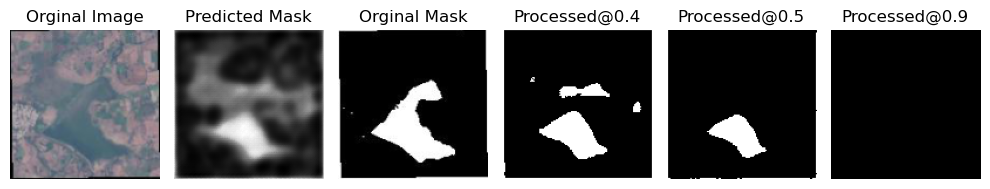

144/144 ━━━━━━━━━━━━━━━━━━━━ 64s 445ms/step - accuracy: 0.6382 - loss: 0.4881 - val_accuracy: 0.6586 - val_loss: 0.4487
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.6566 - loss: 0.4622
Epoch 3: val_loss did not improve from 0.44873
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


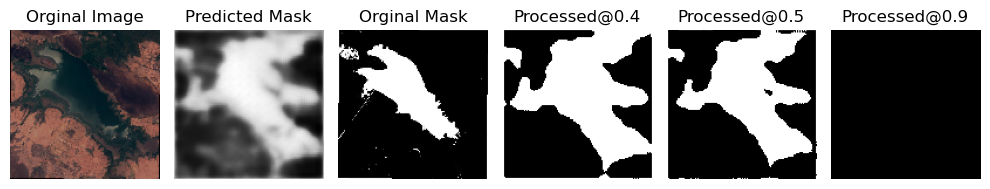

144/144 ━━━━━━━━━━━━━━━━━━━━ 83s 574ms/step - accuracy: 0.6566 - loss: 0.4621 - val_accuracy: 0.6502 - val_loss: 0.4634
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.6556 - loss: 0.4586
Epoch 4: val_loss improved from 0.44873 to 0.42548, saving model to model_for_watershed.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


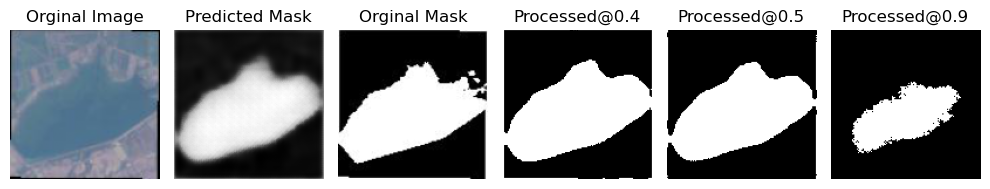

144/144 ━━━━━━━━━━━━━━━━━━━━ 95s 658ms/step - accuracy: 0.6557 - loss: 0.4585 - val_accuracy: 0.6564 - val_loss: 0.4255
Epoch 5/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.6628 - loss: 0.4324
Epoch 5: val_loss improved from 0.42548 to 0.37484, saving model to model_for_watershed.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


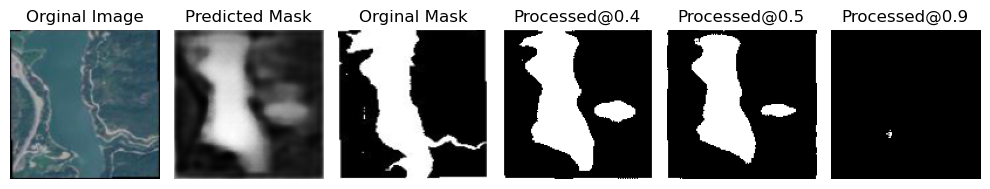

144/144 ━━━━━━━━━━━━━━━━━━━━ 91s 625ms/step - accuracy: 0.6629 - loss: 0.4324 - val_accuracy: 0.6886 - val_loss: 0.3748
Epoch 6/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.6670 - loss: 0.4164
Epoch 6: val_loss improved from 0.37484 to 0.36198, saving model to model_for_watershed.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


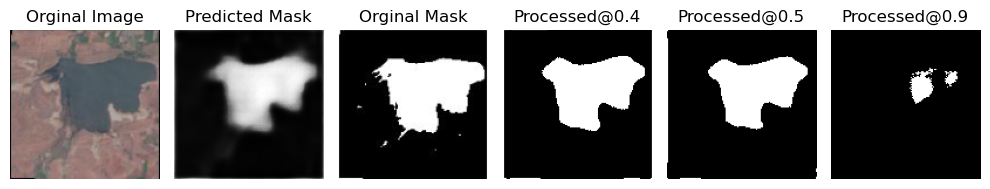

144/144 ━━━━━━━━━━━━━━━━━━━━ 105s 733ms/step - accuracy: 0.6671 - loss: 0.4164 - val_accuracy: 0.6988 - val_loss: 0.3620
Epoch 7/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.6850 - loss: 0.3986
Epoch 7: val_loss did not improve from 0.36198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


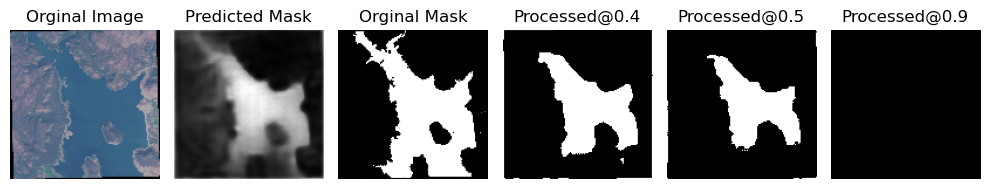

144/144 ━━━━━━━━━━━━━━━━━━━━ 72s 501ms/step - accuracy: 0.6849 - loss: 0.3986 - val_accuracy: 0.6759 - val_loss: 0.4074
Epoch 8/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6730 - loss: 0.4080
Epoch 8: val_loss did not improve from 0.36198
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


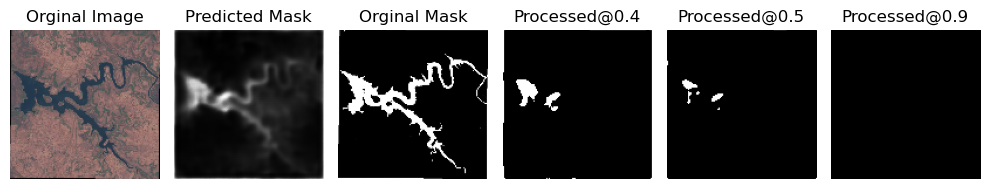

144/144 ━━━━━━━━━━━━━━━━━━━━ 66s 461ms/step - accuracy: 0.6730 - loss: 0.4079 - val_accuracy: 0.6834 - val_loss: 0.3824
Epoch 9/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.6919 - loss: 0.3805
Epoch 9: val_loss improved from 0.36198 to 0.34835, saving model to model_for_watershed.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


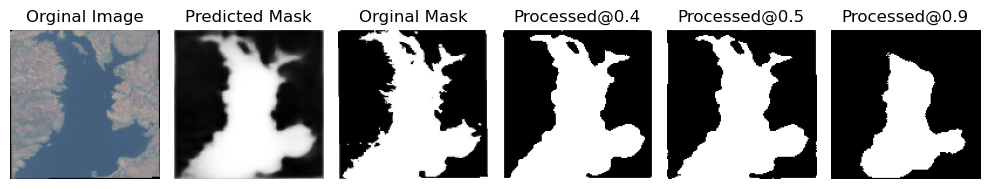

144/144 ━━━━━━━━━━━━━━━━━━━━ 61s 422ms/step - accuracy: 0.6919 - loss: 0.3805 - val_accuracy: 0.6981 - val_loss: 0.3483
Epoch 10/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.6972 - loss: 0.3673
Epoch 10: val_loss did not improve from 0.34835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


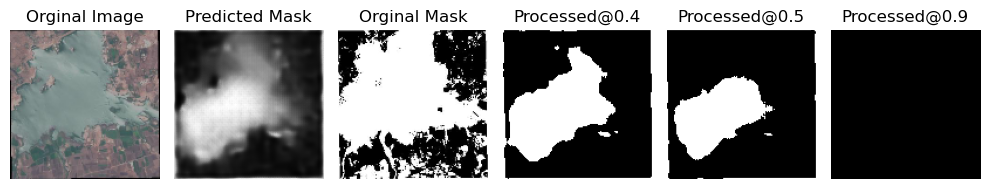

144/144 ━━━━━━━━━━━━━━━━━━━━ 61s 427ms/step - accuracy: 0.6972 - loss: 0.3673 - val_accuracy: 0.6995 - val_loss: 0.3494
Epoch 11/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.6859 - loss: 0.3787
Epoch 11: val_loss did not improve from 0.34835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


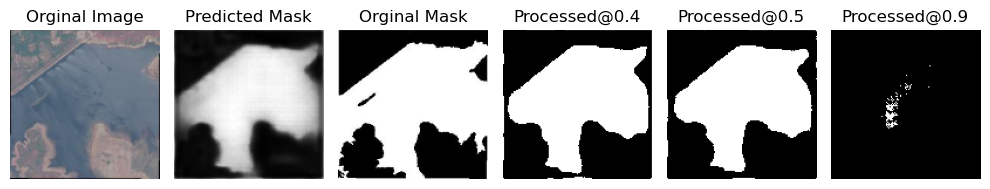

144/144 ━━━━━━━━━━━━━━━━━━━━ 60s 420ms/step - accuracy: 0.6859 - loss: 0.3787 - val_accuracy: 0.6948 - val_loss: 0.3633
Epoch 12/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.6893 - loss: 0.3723
Epoch 12: val_loss did not improve from 0.34835
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


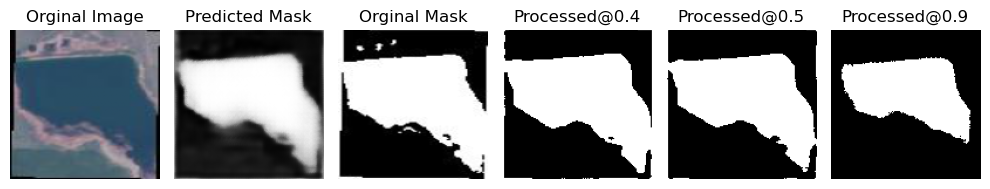

144/144 ━━━━━━━━━━━━━━━━━━━━ 60s 417ms/step - accuracy: 0.6893 - loss: 0.3723 - val_accuracy: 0.6978 - val_loss: 0.3554


In [22]:
model.fit(X, y, batch_size=16, epochs=30, validation_split=0.1, callbacks=callbacks)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


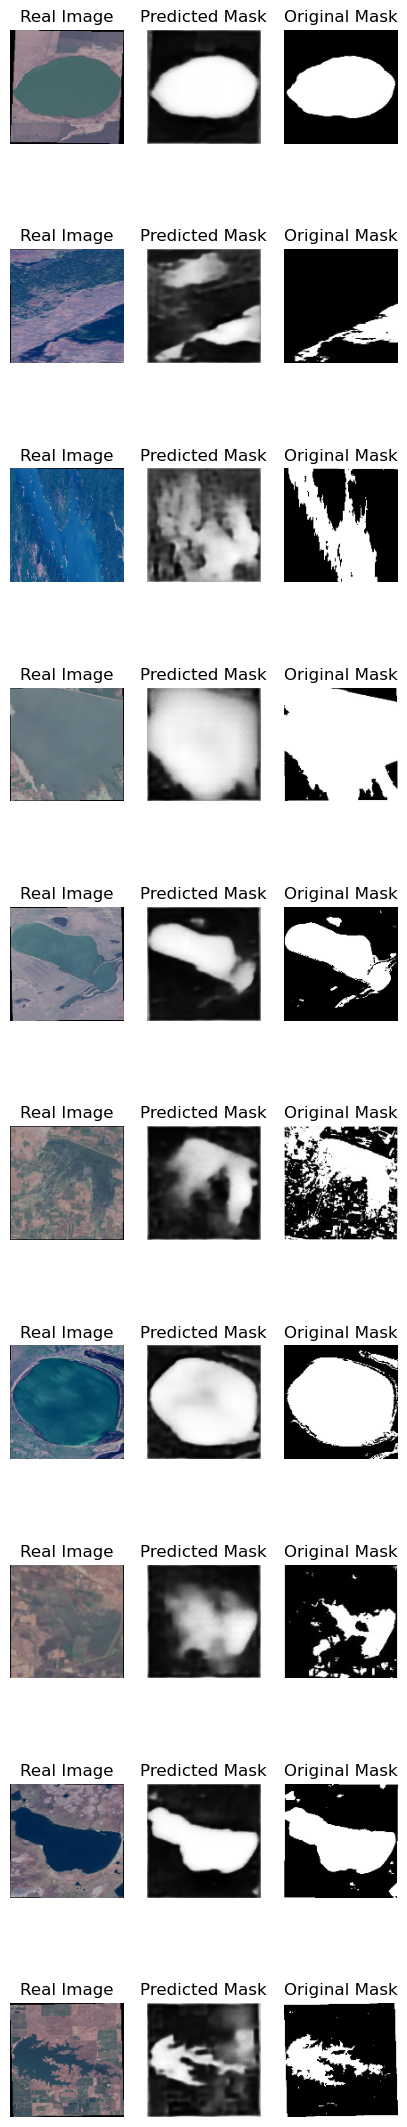

In [23]:
plt.figure(figsize=(5,28))
n=0
for i in range(1,31):
    plt.subplot(10,3,i)
    
    if n==0:
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = model.predict(real_img).reshape(128,128)
        mask = masks[id].reshape(128,128)
        show_image(real_img[0], title="Real Image")
        n+=1
    elif n==1:
        show_image(pred_mask, title="Predicted Mask", cmap='gray')
        n+=1
    elif n==2:
        show_image(mask, title="Original Mask", cmap='gray')
        n=0